# Retinal Vessel Extraction - Sauvola vs Niblack

trying to extract blood vessels from fundus images using local thresholding. the idea is to compare niblack and sauvola and see which one is better at detecting thin vessels

using DRIVE dataset from kaggle
- training folder has images, masks and ground truth (1st_manual)
- test folder has images and masks but no ground truth

In [1]:
# !pip install scikit-image opencv-python matplotlib scikit-learn pillow

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.filters import threshold_niblack, threshold_sauvola
from skimage.morphology import skeletonize
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print('done')

done


In [3]:
# change this to where you extracted the zip
base = r'/home/patan/Downloads/archive/Retinal/archive/DRIVE'

# all results/plots will be saved here
results_dir = os.path.join(base, 'results')
os.makedirs(results_dir, exist_ok=True)
print('results will be saved to:', results_dir)

results will be saved to: /home/patan/Downloads/archive/Retinal/archive/DRIVE/results


In [4]:
tr_imgs  = os.path.join(base, 'training', 'images')
tr_masks = os.path.join(base, 'training', 'mask')
tr_gt    = os.path.join(base, 'training', '1st_manual')
te_imgs  = os.path.join(base, 'test', 'images')
te_masks = os.path.join(base, 'test', 'mask')

def get_files(folder):
    ok = ('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.ppm', '.gif', '.bmp')
    return sorted([os.path.join(folder, f) for f in os.listdir(folder)
                   if f.lower().endswith(ok)])

tr_img_list  = get_files(tr_imgs)
tr_mask_list = get_files(tr_masks)
tr_gt_list   = get_files(tr_gt)
te_img_list  = get_files(te_imgs)
te_mask_list = get_files(te_masks)

print('train images :', len(tr_img_list))
print('ground truth :', len(tr_gt_list))
print('test images  :', len(te_img_list))
print('gt files found:', [os.path.basename(f) for f in tr_gt_list[:5]])

train images : 20
ground truth : 20
test images  : 20
gt files found: ['21_manual1.gif', '22_manual1.gif', '23_manual1.gif', '24_manual1.gif', '25_manual1.gif']


In [5]:
# using PIL to read - handles gif, tif, ppm without issues
def read_rgb(p):
    return np.array(Image.open(p).convert('RGB'))

def read_gray(p):
    return np.array(Image.open(p).convert('L'))

# test
print('img shape:', read_rgb(tr_img_list[0]).shape)
print('gt shape :', read_gray(tr_gt_list[0]).shape)

img shape: (584, 565, 3)
gt shape : (584, 565)


## look at the data first

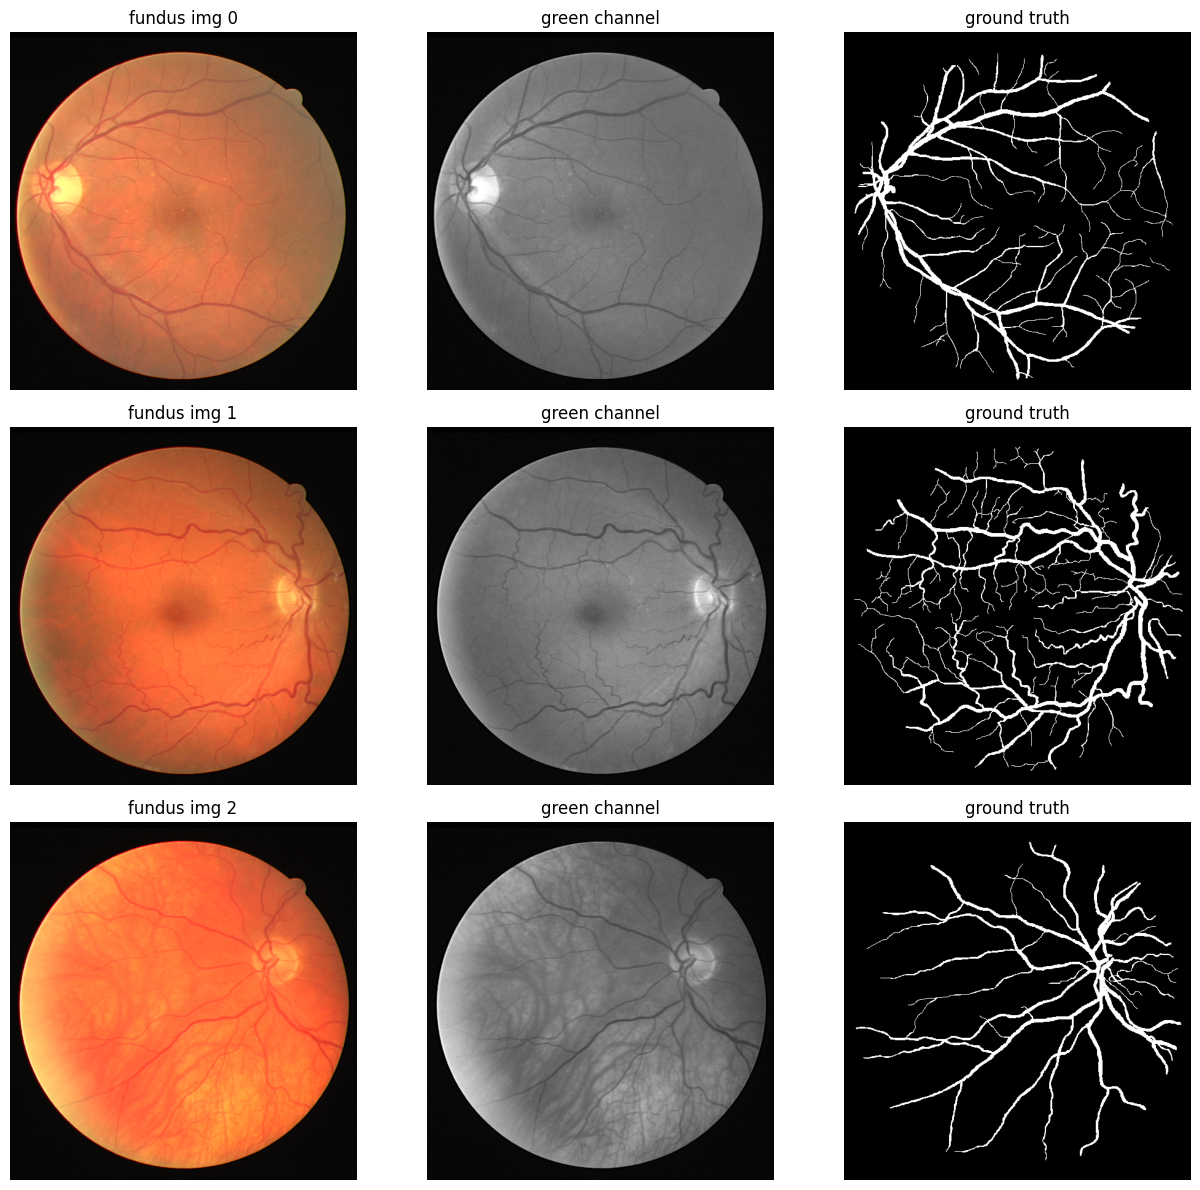

saved: 01_dataset_samples.png


In [6]:
n_show = min(3, len(tr_img_list), len(tr_gt_list))

fig, axes = plt.subplots(n_show, 3, figsize=(13, 4*n_show))

for i in range(n_show):
    rgb = read_rgb(tr_img_list[i])
    gt  = read_gray(tr_gt_list[i])

    axes[i][0].imshow(rgb);                  axes[i][0].set_title(f'fundus img {i}'); axes[i][0].axis('off')
    axes[i][1].imshow(rgb[:,:,1], cmap='gray'); axes[i][1].set_title('green channel'); axes[i][1].axis('off')
    axes[i][2].imshow(gt, cmap='gray');      axes[i][2].set_title('ground truth');   axes[i][2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '01_dataset_samples.png'), dpi=150, bbox_inches='tight')
plt.show()
print('saved: 01_dataset_samples.png')

## preprocessing

steps:
1. take green channel - vessels stand out more here
2. CLAHE to fix uneven lighting
3. invert so vessels are bright (thresholding works better that way)

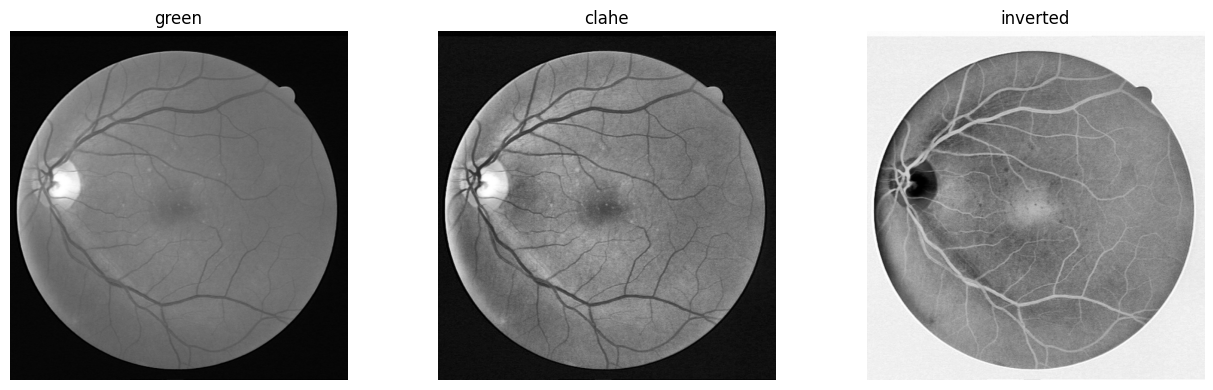

saved: 02_preprocessing.png


In [7]:
def preprocess(path):
    rgb = read_rgb(path)
    green = rgb[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enh = clahe.apply(green)
    inv = cv2.bitwise_not(enh)
    return green, enh, inv


g, enh, inv = preprocess(tr_img_list[0])

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
axes[0].imshow(g, cmap='gray');   axes[0].set_title('green'); axes[0].axis('off')
axes[1].imshow(enh, cmap='gray'); axes[1].set_title('clahe'); axes[1].axis('off')
axes[2].imshow(inv, cmap='gray'); axes[2].set_title('inverted'); axes[2].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, '02_preprocessing.png'), dpi=150, bbox_inches='tight')
plt.show()
print('saved: 02_preprocessing.png')

## Niblack and Sauvola thresholding

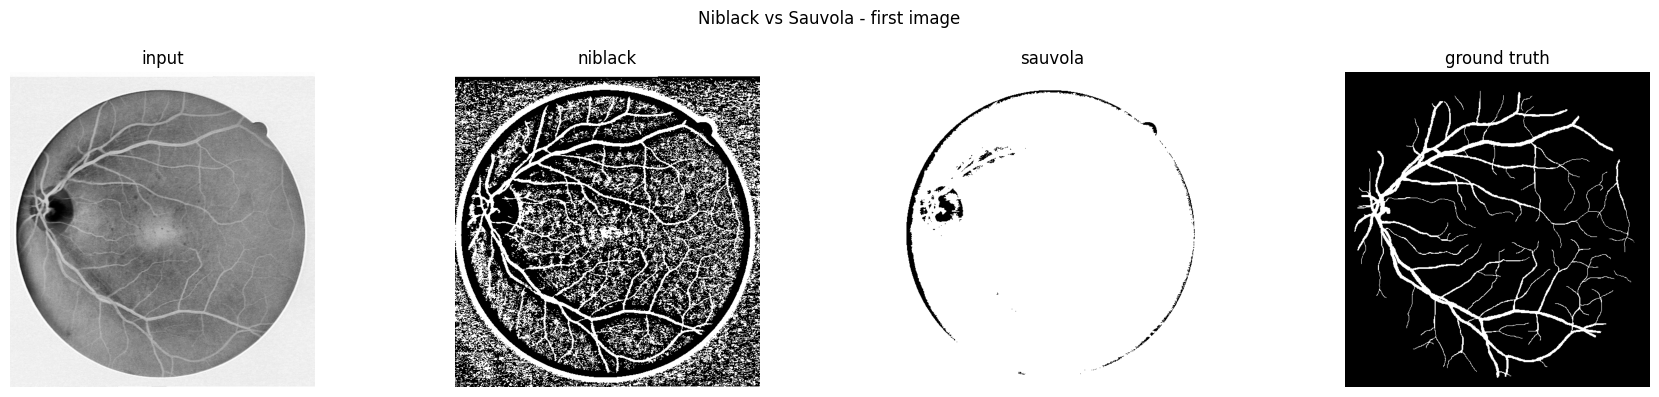

saved: 03_niblack_vs_sauvola_img0.png


In [8]:
def niblack(gray, w=25, k=-0.2):
    t = threshold_niblack(gray, window_size=w, k=k)
    return ((gray > t) * 255).astype(np.uint8)

def sauvola(gray, w=25, k=0.5, r=128):
    t = threshold_sauvola(gray, window_size=w, k=k, r=r)
    return ((gray > t) * 255).astype(np.uint8)


g, enh, inv = preprocess(tr_img_list[0])
nb  = niblack(inv)
sv  = sauvola(inv)
gt0 = read_gray(tr_gt_list[0])

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
axes[0].imshow(inv, cmap='gray');  axes[0].set_title('input');        axes[0].axis('off')
axes[1].imshow(nb, cmap='gray');   axes[1].set_title('niblack');      axes[1].axis('off')
axes[2].imshow(sv, cmap='gray');   axes[2].set_title('sauvola');      axes[2].axis('off')
axes[3].imshow(gt0, cmap='gray');  axes[3].set_title('ground truth'); axes[3].axis('off')
plt.suptitle('Niblack vs Sauvola - first image')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, '03_niblack_vs_sauvola_img0.png'), dpi=150, bbox_inches='tight')
plt.show()
print('saved: 03_niblack_vs_sauvola_img0.png')

## side by side on all training images

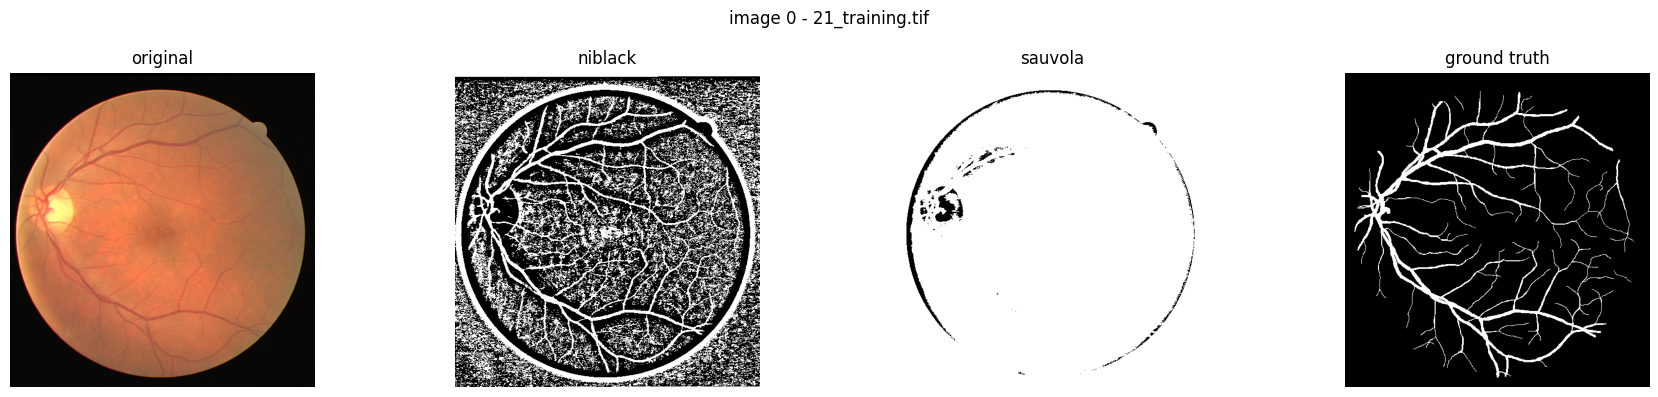

saved: 04_comparison_img0.png


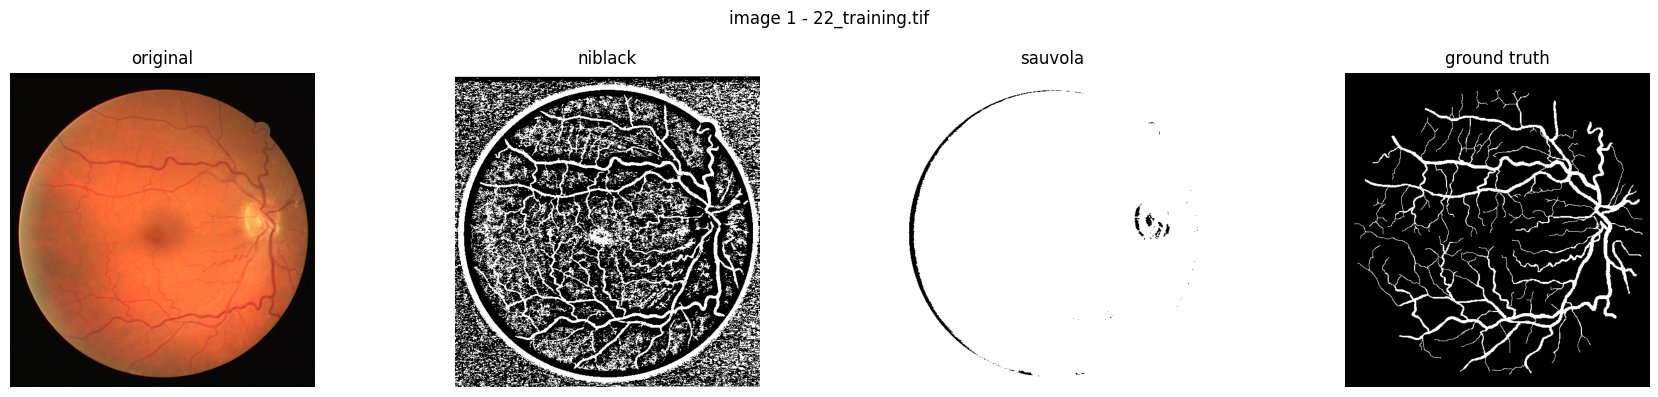

saved: 04_comparison_img1.png


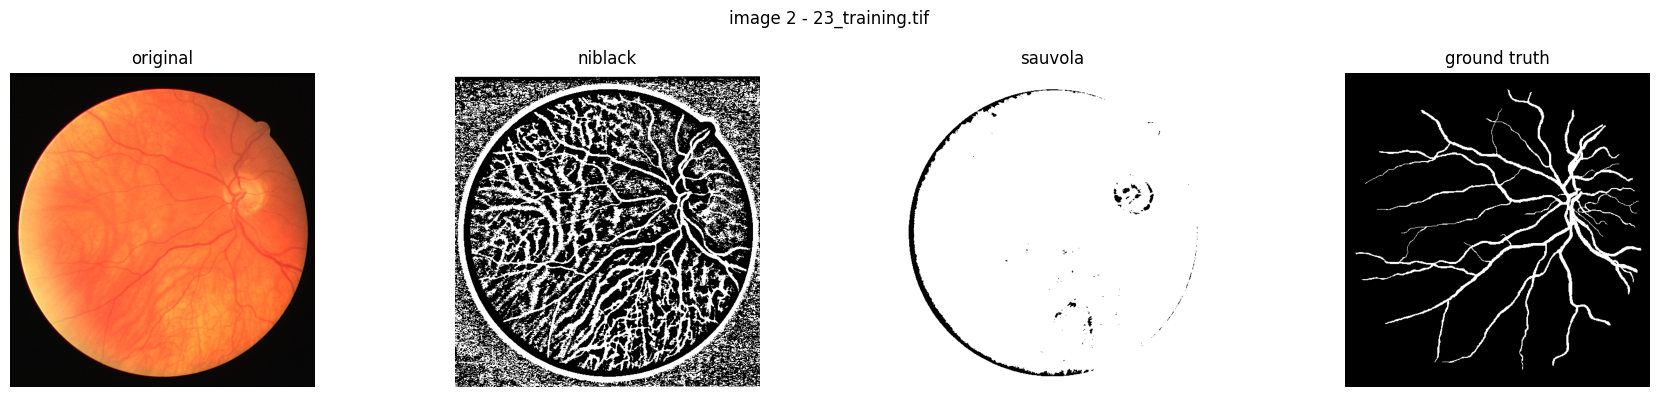

saved: 04_comparison_img2.png


In [9]:
n_show = min(3, len(tr_img_list), len(tr_gt_list))

for i in range(n_show):
    g, enh, inv = preprocess(tr_img_list[i])
    nb  = niblack(inv)
    sv  = sauvola(inv)
    gt  = read_gray(tr_gt_list[i])

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    axes[0].imshow(read_rgb(tr_img_list[i])); axes[0].set_title('original');    axes[0].axis('off')
    axes[1].imshow(nb, cmap='gray');          axes[1].set_title('niblack');      axes[1].axis('off')
    axes[2].imshow(sv, cmap='gray');          axes[2].set_title('sauvola');      axes[2].axis('off')
    axes[3].imshow(gt, cmap='gray');          axes[3].set_title('ground truth'); axes[3].axis('off')
    plt.suptitle(f'image {i} - {os.path.basename(tr_img_list[i])}')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'04_comparison_img{i}.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f'saved: 04_comparison_img{i}.png')

## zoom into thin vessel region

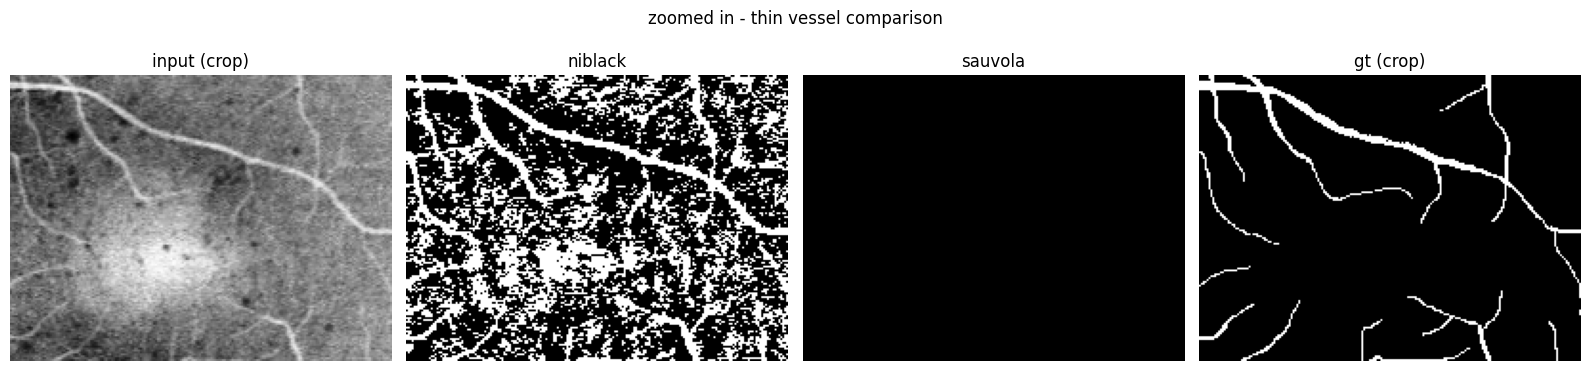

saved: 05_thin_vessel_zoom.png


In [10]:
g, enh, inv = preprocess(tr_img_list[0])
nb  = niblack(inv)
sv  = sauvola(inv)
gt0 = read_gray(tr_gt_list[0])

# adjust if needed
r1, r2, c1, c2 = 200, 350, 200, 400

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(inv[r1:r2, c1:c2], cmap='gray');  axes[0].set_title('input (crop)');  axes[0].axis('off')
axes[1].imshow(nb[r1:r2, c1:c2], cmap='gray');   axes[1].set_title('niblack');        axes[1].axis('off')
axes[2].imshow(sv[r1:r2, c1:c2], cmap='gray');   axes[2].set_title('sauvola');        axes[2].axis('off')
axes[3].imshow(gt0[r1:r2, c1:c2], cmap='gray');  axes[3].set_title('gt (crop)');      axes[3].axis('off')
plt.suptitle('zoomed in - thin vessel comparison')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, '05_thin_vessel_zoom.png'), dpi=150, bbox_inches='tight')
plt.show()
print('saved: 05_thin_vessel_zoom.png')

## effect of window size on thin vessel detection

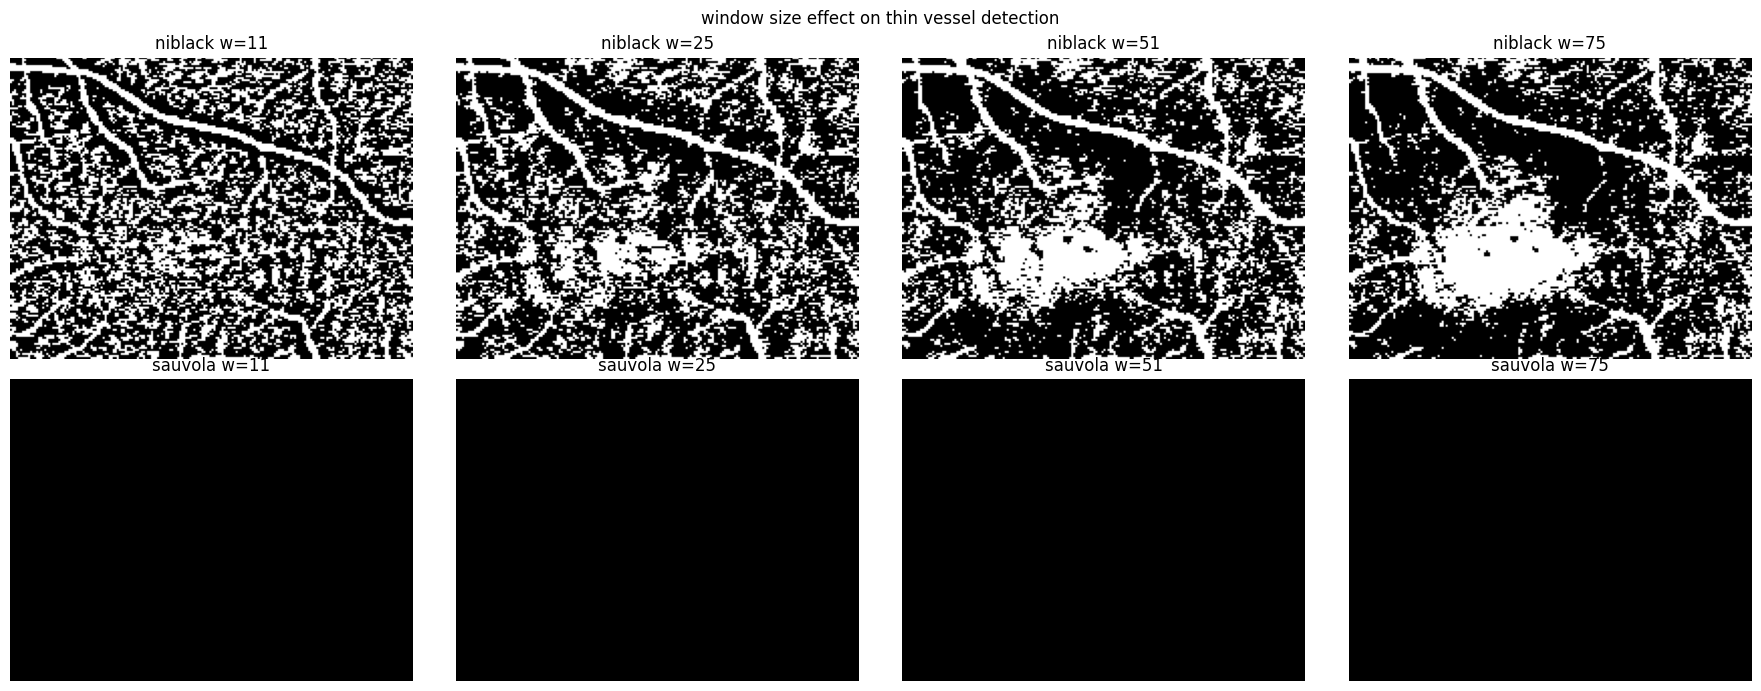

saved: 06_window_size_effect.png


In [11]:
ws_list = [11, 25, 51, 75]

fig, axes = plt.subplots(2, len(ws_list), figsize=(18, 7))

for j, ws in enumerate(ws_list):
    n = niblack(inv, w=ws)
    s = sauvola(inv, w=ws)

    axes[0][j].imshow(n[r1:r2, c1:c2], cmap='gray'); axes[0][j].set_title(f'niblack w={ws}'); axes[0][j].axis('off')
    axes[1][j].imshow(s[r1:r2, c1:c2], cmap='gray'); axes[1][j].set_title(f'sauvola w={ws}'); axes[1][j].axis('off')

plt.suptitle('window size effect on thin vessel detection')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, '06_window_size_effect.png'), dpi=150, bbox_inches='tight')
plt.show()
print('saved: 06_window_size_effect.png')

## evaluation against ground truth

In [12]:
def evaluate(pred, gt, fov=None):
    p = (pred > 127).astype(int).flatten()
    g = (gt   > 127).astype(int).flatten()
    if fov is not None:
        mask = (fov > 0).flatten()
        p, g = p[mask], g[mask]
    tn, fp, fn, tp = confusion_matrix(g, p, labels=[0, 1]).ravel()
    sens = tp / (tp + fn + 1e-9)
    spec = tn / (tn + fp + 1e-9)
    f1   = f1_score(g, p, zero_division=0)
    try:
        auc = roc_auc_score(g, p)
    except:
        auc = 0.0
    return sens, spec, f1, auc


nib_res, sauv_res = [], []
rows = []

print(f'{"file":28s}  method     sens    spec    f1      auc')
print('-' * 78)

for ip, gp, mp in zip(tr_img_list, tr_gt_list, tr_mask_list):
    g, enh, inv = preprocess(ip)
    gt  = read_gray(gp)
    fov = read_gray(mp)
    nb  = niblack(inv)
    sv  = sauvola(inv)

    nr = evaluate(nb, gt, fov)
    sr = evaluate(sv, gt, fov)
    nib_res.append(nr)
    sauv_res.append(sr)

    name = os.path.basename(ip)
    rows.append({'image': name, 'method': 'niblack', 'sensitivity': nr[0], 'specificity': nr[1], 'f1': nr[2], 'auc': nr[3]})
    rows.append({'image': name, 'method': 'sauvola', 'sensitivity': sr[0], 'specificity': sr[1], 'f1': sr[2], 'auc': sr[3]})

    print(f'{name:28s}  niblack    {nr[0]:.3f}   {nr[1]:.3f}   {nr[2]:.3f}   {nr[3]:.3f}')
    print(f'{"":28s}  sauvola    {sr[0]:.3f}   {sr[1]:.3f}   {sr[2]:.3f}   {sr[3]:.3f}')

na = np.array(nib_res)
sa = np.array(sauv_res)
print('=' * 78)
print(f'{"AVG":28s}  niblack    {na[:,0].mean():.3f}   {na[:,1].mean():.3f}   {na[:,2].mean():.3f}   {na[:,3].mean():.3f}')
print(f'{"":28s}  sauvola    {sa[:,0].mean():.3f}   {sa[:,1].mean():.3f}   {sa[:,2].mean():.3f}   {sa[:,3].mean():.3f}')

# save results to csv
results_df = pd.DataFrame(rows)
csv_path = os.path.join(results_dir, 'metrics.csv')
results_df.to_csv(csv_path, index=False)
print(f'\nsaved metrics to: metrics.csv')

file                          method     sens    spec    f1      auc
------------------------------------------------------------------------------
21_training.tif               niblack    0.846   0.727   0.416   0.787
                              sauvola    0.989   0.040   0.202   0.515
22_training.tif               niblack    0.804   0.752   0.466   0.778
                              sauvola    0.995   0.022   0.235   0.509
23_training.tif               niblack    0.821   0.691   0.345   0.756
                              sauvola    0.994   0.038   0.178   0.516
24_training.tif               niblack    0.797   0.768   0.540   0.782
                              sauvola    0.987   0.061   0.297   0.524
25_training.tif               niblack    0.739   0.712   0.420   0.726
                              sauvola    0.997   0.010   0.246   0.503
26_training.tif               niblack    0.803   0.714   0.416   0.759
                              sauvola    0.999   0.003   0.218   0.501


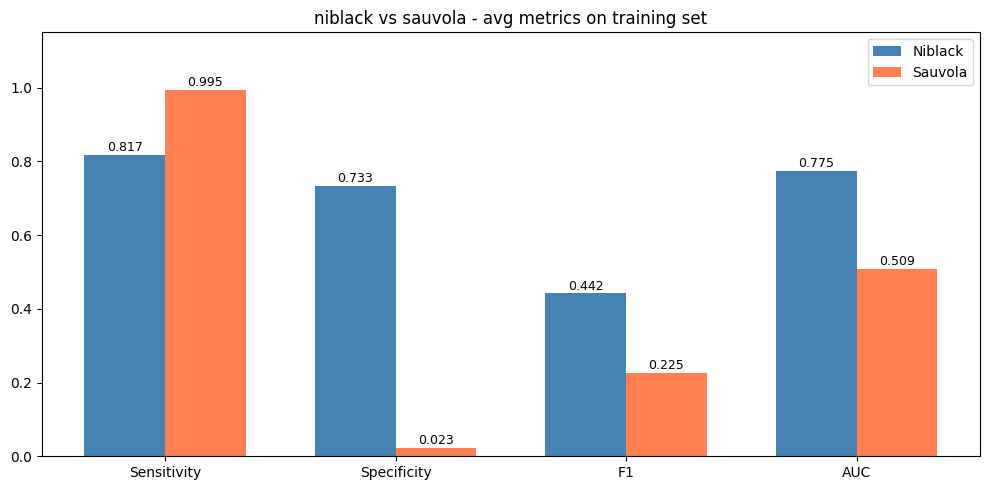

saved: 07_metrics_barchart.png


In [13]:
metrics = ['Sensitivity', 'Specificity', 'F1', 'AUC']
x = np.arange(len(metrics))
w = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
b1 = ax.bar(x - w/2, na.mean(axis=0), w, label='Niblack', color='steelblue')
b2 = ax.bar(x + w/2, sa.mean(axis=0), w, label='Sauvola', color='coral')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.15)
ax.set_title('niblack vs sauvola - avg metrics on training set')
ax.legend()

for b in list(b1) + list(b2):
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.01,
            f'{b.get_height():.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, '07_metrics_barchart.png'), dpi=150, bbox_inches='tight')
plt.show()
print('saved: 07_metrics_barchart.png')

## thin vessel sensitivity (skeleton-based)

In [14]:
def thin_sens(pred, gt):
    pred_b = pred > 127
    gt_b   = gt   > 127
    skel   = skeletonize(gt_b)
    detected = (pred_b & skel).sum()
    return detected / (skel.sum() + 1e-9), skel


nib_thin, sauv_thin = [], []

print(f'{"file":28s}  niblack    sauvola')
print('-' * 52)

for ip, gp in zip(tr_img_list, tr_gt_list):
    g, enh, inv = preprocess(ip)
    gt = read_gray(gp)
    nb = niblack(inv)
    sv = sauvola(inv)
    n_t, _ = thin_sens(nb, gt)
    s_t, _ = thin_sens(sv, gt)
    nib_thin.append(n_t)
    sauv_thin.append(s_t)
    print(f'{os.path.basename(ip):28s}  {n_t:.4f}     {s_t:.4f}')

print('-' * 52)
print(f'{"AVERAGE":28s}  {np.mean(nib_thin):.4f}     {np.mean(sauv_thin):.4f}')

file                          niblack    sauvola
----------------------------------------------------
21_training.tif               0.8972     0.9938
22_training.tif               0.8365     0.9956
23_training.tif               0.8911     0.9928
24_training.tif               0.8414     0.9878
25_training.tif               0.7778     0.9973
26_training.tif               0.8588     1.0000
27_training.tif               0.8500     0.9945
28_training.tif               0.8256     0.9968
29_training.tif               0.8199     0.9998
30_training.tif               0.8494     0.9963
31_training.tif               0.8625     0.9870
32_training.tif               0.8627     0.9928
33_training.tif               0.8629     0.9947
34_training.tif               0.8230     0.9983
35_training.tif               0.8650     0.9993
36_training.tif               0.8537     0.9991
37_training.tif               0.8689     0.9985
38_training.tif               0.8706     0.9970
39_training.tif               0.87

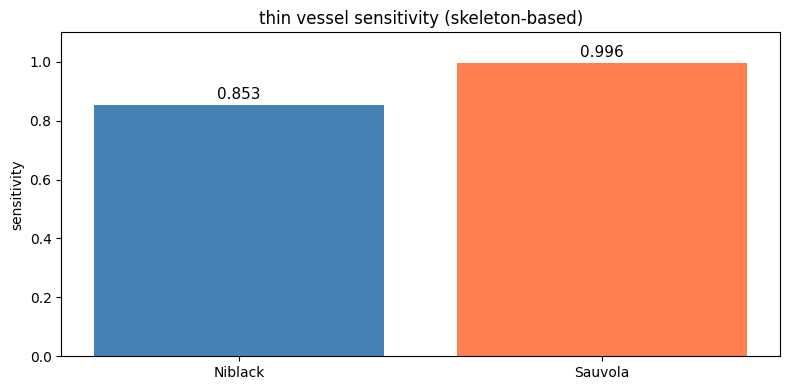

saved: 08_thin_vessel_sensitivity.png


In [15]:
# bar chart for thin vessel sensitivity
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(['Niblack', 'Sauvola'], [np.mean(nib_thin), np.mean(sauv_thin)], color=['steelblue', 'coral'])
ax.set_title('thin vessel sensitivity (skeleton-based)')
ax.set_ylabel('sensitivity')
ax.set_ylim(0, 1.1)
for i, v in enumerate([np.mean(nib_thin), np.mean(sauv_thin)]):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, '08_thin_vessel_sensitivity.png'), dpi=150, bbox_inches='tight')
plt.show()
print('saved: 08_thin_vessel_sensitivity.png')

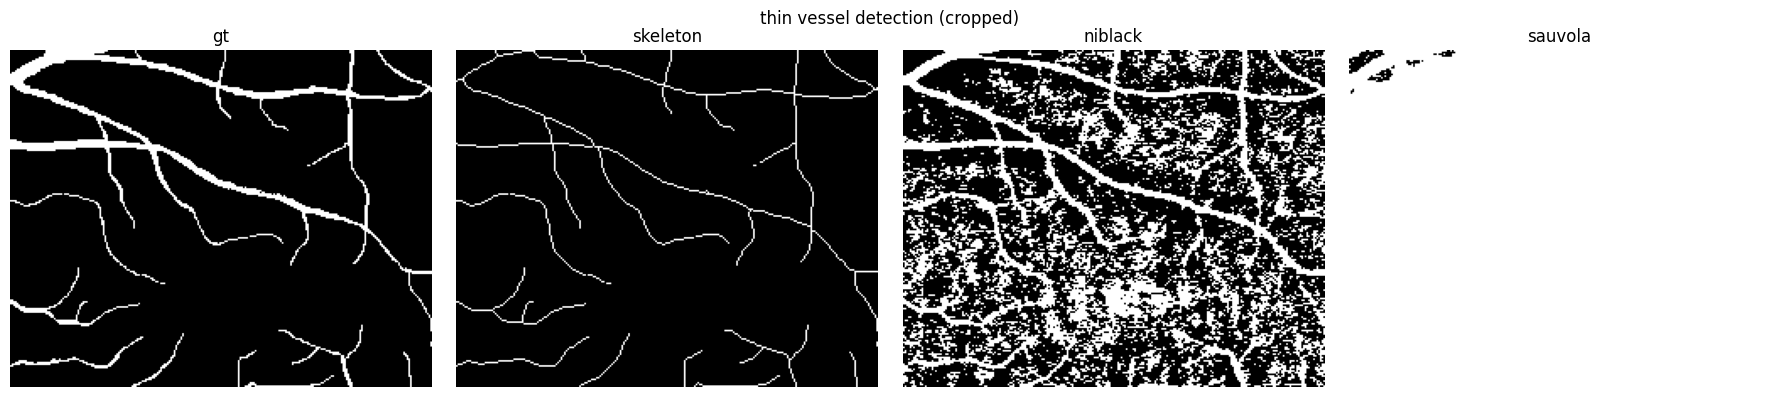

saved: 09_skeleton_comparison.png


In [16]:
# visualise skeleton vs detected
g, enh, inv = preprocess(tr_img_list[0])
gt0  = read_gray(tr_gt_list[0])
nb   = niblack(inv)
sv   = sauvola(inv)
_, skel = thin_sens(nb, gt0)

r1, r2, c1, c2 = 150, 350, 150, 400

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
axes[0].imshow(gt0[r1:r2,c1:c2], cmap='gray');   axes[0].set_title('gt');       axes[0].axis('off')
axes[1].imshow(skel[r1:r2,c1:c2], cmap='gray');  axes[1].set_title('skeleton'); axes[1].axis('off')
axes[2].imshow(nb[r1:r2,c1:c2], cmap='gray');    axes[2].set_title('niblack');  axes[2].axis('off')
axes[3].imshow(sv[r1:r2,c1:c2], cmap='gray');    axes[3].set_title('sauvola');  axes[3].axis('off')
plt.suptitle('thin vessel detection (cropped)')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, '09_skeleton_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()
print('saved: 09_skeleton_comparison.png')

## test set results

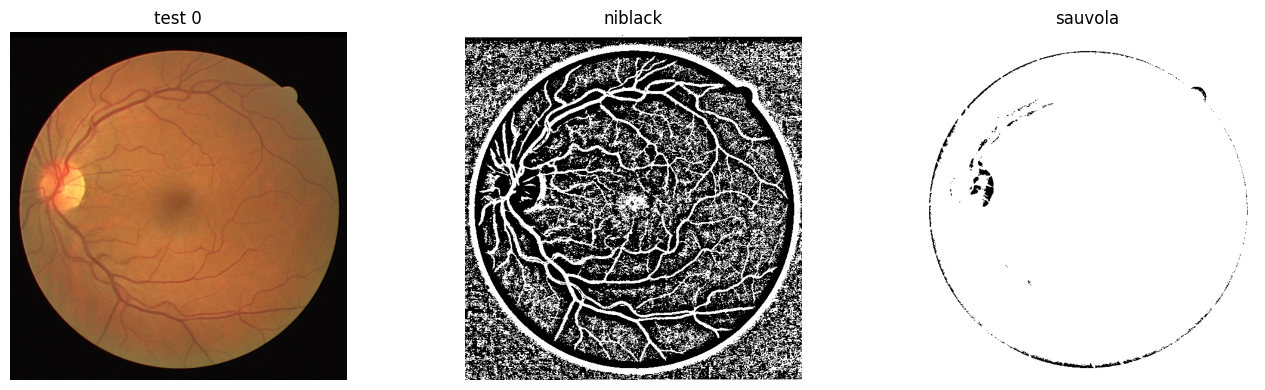

saved: 10_test_img0.png


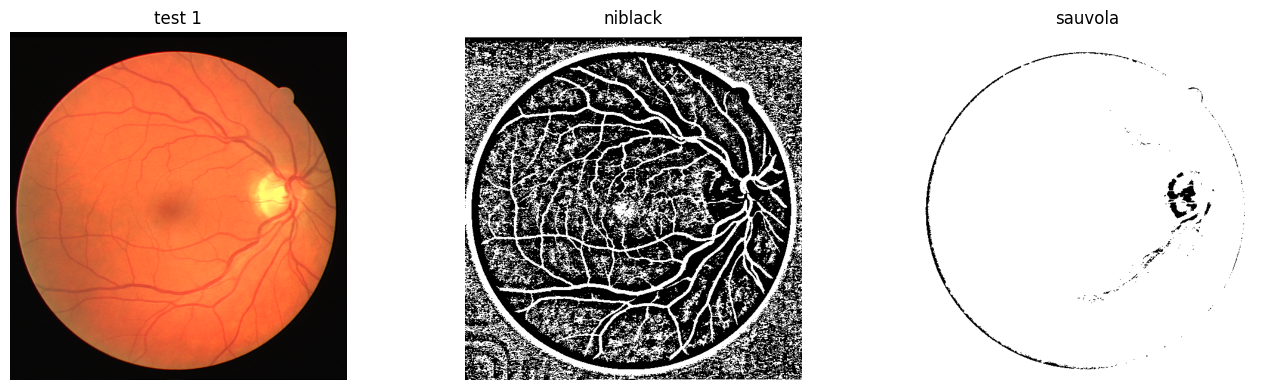

saved: 10_test_img1.png


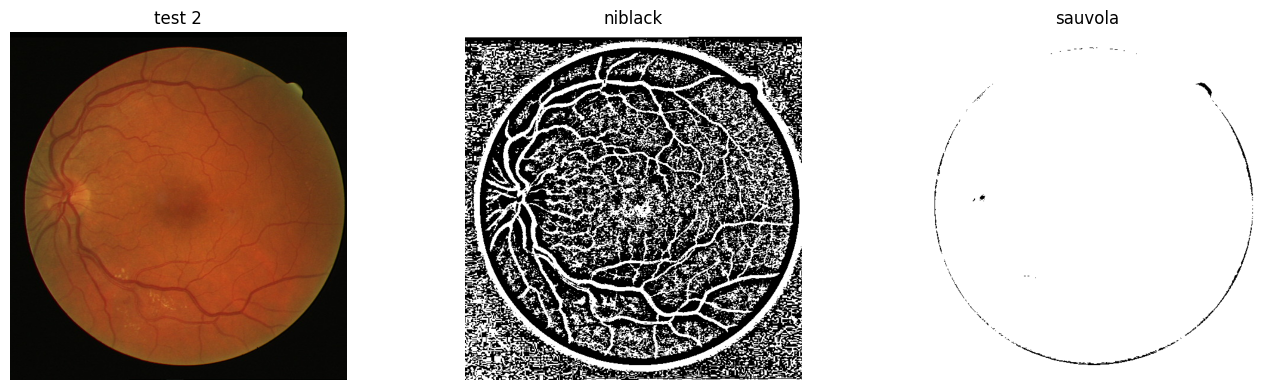

saved: 10_test_img2.png

test masks saved as png files


In [17]:
for i, ip in enumerate(te_img_list[:3]):
    g, enh, inv = preprocess(ip)
    nb = niblack(inv)
    sv = sauvola(inv)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    axes[0].imshow(read_rgb(ip));    axes[0].set_title(f'test {i}'); axes[0].axis('off')
    axes[1].imshow(nb, cmap='gray'); axes[1].set_title('niblack');   axes[1].axis('off')
    axes[2].imshow(sv, cmap='gray'); axes[2].set_title('sauvola');   axes[2].axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'10_test_img{i}.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f'saved: 10_test_img{i}.png')

    # also save the actual segmentation masks
    Image.fromarray(nb).save(os.path.join(results_dir, f'test{i}_niblack_mask.png'))
    Image.fromarray(sv).save(os.path.join(results_dir, f'test{i}_sauvola_mask.png'))

print('\ntest masks saved as png files')

## final summary

In [18]:
summary = pd.DataFrame({
    'method':           ['niblack',                    'sauvola'],
    'formula':          ['mean + k*std',               'mean*(1 + k*(std/R - 1))'],
    'avg sensitivity':  [f'{na[:,0].mean():.3f}',      f'{sa[:,0].mean():.3f}'],
    'avg f1':           [f'{na[:,2].mean():.3f}',      f'{sa[:,2].mean():.3f}'],
    'thin vessel sens': [f'{np.mean(nib_thin):.3f}',   f'{np.mean(sauv_thin):.3f}'],
    'noise':            ['more',                       'less'],
})

summary.to_csv(os.path.join(results_dir, 'summary.csv'), index=False)
print('saved: summary.csv')
print(f'\nall results saved to: {results_dir}')
print('files saved:')
for f in sorted(os.listdir(results_dir)):
    print(' ', f)

summary

saved: summary.csv

all results saved to: /home/patan/Downloads/archive/Retinal/archive/DRIVE/results
files saved:
  01_dataset_samples.png
  02_preprocessing.png
  03_niblack_vs_sauvola_img0.png
  04_comparison_img0.png
  04_comparison_img1.png
  04_comparison_img2.png
  05_thin_vessel_zoom.png
  06_window_size_effect.png
  07_metrics_barchart.png
  08_thin_vessel_sensitivity.png
  09_skeleton_comparison.png
  10_test_img0.png
  10_test_img1.png
  10_test_img2.png
  metrics.csv
  summary.csv
  test0_niblack_mask.png
  test0_sauvola_mask.png
  test1_niblack_mask.png
  test1_sauvola_mask.png
  test2_niblack_mask.png
  test2_sauvola_mask.png


method                   formula avg sensitivity avg f1 thin vessel sens  \
0  niblack              mean + k*std           0.817  0.442            0.853   
1  sauvola  mean*(1 + k*(std/R - 1))           0.995  0.225            0.996   

  noise  
0  more  
1  less